# VISHNU

This notebook will detail the process of sorting between accreted Milky Way Globular Clusters and in-situ globular clusters using solely dynamical information. The obtained accretion candidates list is to be used in further age-metallicity comparisons to examine the physical differences between these two groups of GC's. 

The general approach to identify accretion candidates from dynamical information will be as follows:

1. Begin from the E-Lz plot and flag clusters with high energy (bigger E means the cluster is likely less bound, 
hence more likely to be accreted) OR clusters with retrograde orbits (Lz < 0), which is another clear sign of accretion

2. Make a dynamical cut in the negative Lz, high energy region of the plot. Ensure that the cut is broad, so that candidates which don't fit the trend spatially can be removed later. Expect approximately 30-45 GC's within the cut before trimming. 

3. Next, plot candidates against the remaining population spatially (R vs |z|), in terms of eccentricity (eccentricity vs E) and in terms of their apocentric distances. Determine if these candidates are outliers in these plots as well. If they are, then this is a further sign of accretion. If they are not, and don't fit the trend spatially, then remove them from the accretion candidates. list. Make a spatial cut so that any GC classified as in-situ beyond the radius of 15kpc is reclassified as an accreted cluster 

4. Compare with the age-metallicity plots from Sav. Cross check that the candidates are generally younger and more metal-poor than the 
in-situ population. Cross any off the list that are not. We will end up then with a final list of accretion candidates.



## Data preparation

In [2]:
# IMPORTS
import numpy as np
import matplotlib.pyplot as plt
import astropy as ap
from astropy import units as u
import pandas as pd
from astropy.coordinates import SkyCoord, ICRS, Galactic, Galactocentric
from galpy.potential import MWPotential2014
from galpy.orbit import Orbit

In [3]:
# Read in the data

positions_df = pd.read_csv(r"C:\Users\vishn\Desktop\University(work)\PHYS3116 (Galaxies + Cosmology)\Computational Assignment\Data\HarrisPartI.csv")
velocities_df = pd.read_csv(r"C:\Users\vishn\Desktop\University(work)\PHYS3116 (Galaxies + Cosmology)\Computational Assignment\Data\HarrisPartIII.csv")
data_df = pd.merge(positions_df, velocities_df, on="ID")

# We can see that there is no energy or angular momentum in the data. We will have to calculate these ourselves.
print(data_df.keys())

# Extract relevant columns
R_GC = data_df["R_gc"].values * u.kpc  # Galactocentric distance
v_LSR = data_df["v_LSR"].values * u.km / u.s  # Radial velocity
z = data_df["Z"].values * u.kpc  # Height above/below Galactic plane
l = data_df["L"].values * u.deg  # Galactic longitude
b = data_df["B"].values * u.deg  # Galactic latitude
R_sun = data_df["R_Sun"].values * u.kpc  # Distance from Sun

Index(['ID', 'Name', 'RA', 'DEC', 'L', 'B', 'R_Sun', 'R_gc', 'X', 'Y', 'Z',
       'v_r', 'v_r_e', 'v_LSR', 'sig_v', 'sig_v_e', 'c', 'r_c', 'r_h', 'mu_V',
       'rho_0', 'lg_tc', 'lg_th'],
      dtype='object')


## E-Lz plotting and analysis

Accretion candidates based on E-Lz criteria:
['Arp2' 'NGC5024' 'Crater' 'IC4499' 'Pal4' 'NGC5694' 'NGC2298' 'NGC4147'
 'Pal14' 'NGC7089' 'NGC5272' 'NGC6934' 'NGC6101' 'NGC5466' 'Pal5' 'Pal15'
 'Pal13' 'NGC5053' 'NGC6715' 'Pal2' 'NGC1261' 'Whiting1' 'NGC5634'
 'NGC7492' 'Terzan7' 'NGC5904' 'IC1257' 'NGC2419' 'NGC7006' 'NGC6584'
 'NGC3201' 'NGC6229' 'Pyxis' 'NGC1904' 'NGC1851' 'Terzan8' 'NGC6981' 'E1'
 'NGC6864' 'Eridanus' 'AM4' 'FSR1758']
Number of accretion candidates: 42


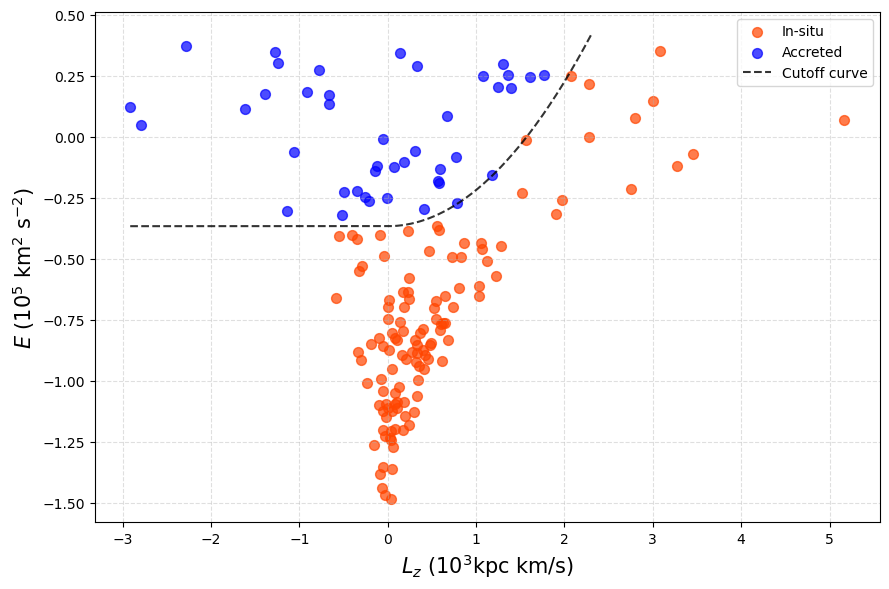

In [11]:
# Harris ID's don't match the naming convention of SIMBAD, so instead I'll be using the Galpy inbuilt globular cluster list
# Galpy globular clusters list. This is fine because SIMBAD pulls from Gaia EDR3 which only has 4 more GC's than Harris. 


# Pulling the inbuilt globular cluster data from galpy. 
# Calculationg analytically to avoid the time cost of orbit integration for each cluster. 
orbits_galpy = Orbit.from_name('MW Globular Clusters')
Lz = []
E = []
names = []
for orb in orbits_galpy:
    names.append(orb.name)
    Lz.append(orb.Lz(pot=MWPotential2014))
    E.append(orb.E(pot=MWPotential2014))

# Extract Lz and E values and convert to numpy arrays
Lz = np.array(Lz, dtype=float)
E = np.array(E, dtype=float)
names = np.array(names)


# Creating a dynamical classification. Soft initial cut. Tunable parameters here.
L0 = 500
E_cutoff = np.percentile(E, 65)
alpha = alpha = 0.05 * (np.max(E) - E_cutoff) 

def E_boundary(lz):
    return np.where(lz < 0, E_cutoff, E_cutoff + alpha * (lz/L0)**2) # if Lz < 0, straight line, if Lz > 0, parabola


mask_accreted = E > E_boundary(Lz)
mask_insitu = np.logical_not(mask_accreted) 

# Print the names of the accretion candidate clusters

print("Accretion candidates based on E-Lz criteria:")
accretion_candidates = np.array(names[mask_accreted])
print(accretion_candidates)
print(f"Number of accretion candidates: {len(accretion_candidates)}")

fig, ax = plt.subplots(figsize=(9,6))
ax.scatter(Lz[mask_insitu]/1e3,   E[mask_insitu]/1e5,   color='orangered', s=50, alpha=0.7, label='In-situ')
ax.scatter(Lz[mask_accreted]/1e3, E[mask_accreted]/1e5, color='blue',s=50, alpha=0.7, label='Accreted')
lz_grid = np.linspace(Lz.min(), 2300, 400)
ax.plot(lz_grid/1e3, E_boundary(lz_grid)/1e5,c = 'black', ls = '--',alpha = 0.8, label = 'Cutoff curve')
ax.set_xlabel(r'$L_z$ ($10^3$kpc km/s)', fontsize=15)
ax.set_ylabel(r'$E$ ($10^5$ km$^2$ s$^{-2}$)', fontsize=15)
ax.grid(True, ls='--', alpha=0.4)
ax.legend()
plt.tight_layout()
plt.show()



## Spatial verification
We will first plot the accretion candidates from the above dynamical cut spatially. We will then justify a cutoff at 15kpc - doing this greatly helped in Sarvpreet's age-metallicity relation plot fixed a lot of the anomalies we had with clusters being classified as in-situ and showing anomalous metallicity/age tracks. 

['ARP2' 'NGC5024' 'IC4499' 'PAL4' 'NGC5694' 'NGC2298' 'NGC4147' 'PAL14'
 'NGC7089' 'NGC5272' 'NGC6934' 'NGC6101' 'NGC5466' 'PAL5' 'PAL15' 'PAL13'
 'NGC5053' 'NGC6715' 'PAL2' 'NGC1261' 'WHITING1' 'NGC5634' 'NGC7492'
 'TERZAN7' 'IC1257' 'NGC2419' 'NGC7006' 'NGC6584' 'NGC3201' 'NGC6229'
 'PYXIS' 'NGC1904' 'NGC1851' 'TERZAN8' 'NGC6981' 'AM1' 'NGC6864'
 'ERIDANUS' 'AM4' 'PAL1' 'KO2' 'PAL3' 'KO1' 'RUP106' 'NGC5824' 'PAL12']


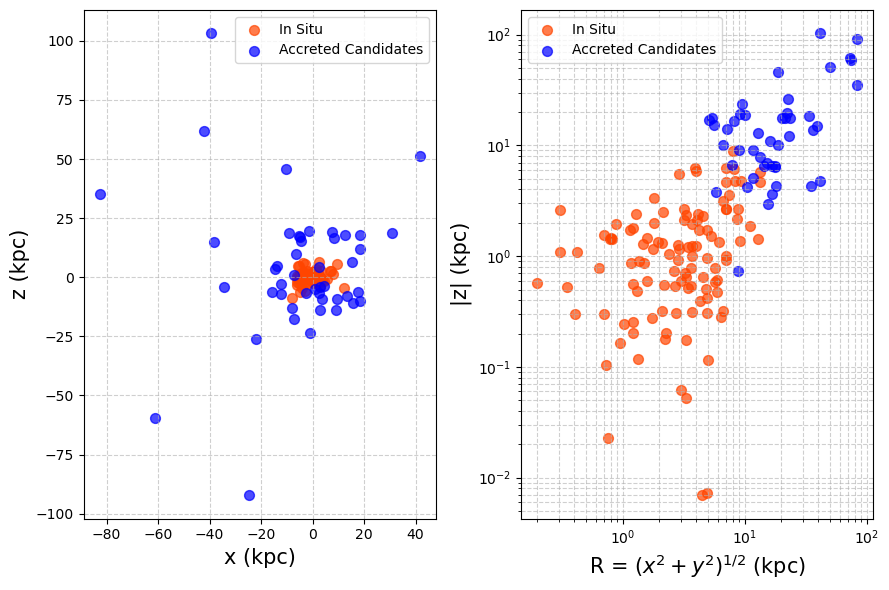

The number of accreted GC's after the spatial cutoff are:  46


In [9]:
# Now, fixing up the naming mismatches and spelling mismatches between the Harris catalogue and the Galpy inbuilt catalogue
# Making everything capital letters and remove spaces in Harris dataframe
data_df['ID'] = data_df['ID'].str.replace(" ", "", regex=False).str.upper()
accretion_candidates = np.char.upper(accretion_candidates.tolist())         # Making everything capital letters (there's already no spaces)

# The first two are not in the Harris catalogue and were discovered recently, so I will remove them
# The third GC has an orbital radius well within the bulge (about R= 2kpc) and is unlikely to be an accretion candidate
accretion_candidates = accretion_candidates[(accretion_candidates != 'CRATER') & (accretion_candidates != 'FSR1758') 
                                            & (accretion_candidates != 'NGC5904')] 

 # This one is in Harris, but named differently.
accretion_candidates = np.where(accretion_candidates == 'E1', 'AM1', accretion_candidates)

print(accretion_candidates)


# Coordinate transforming to the galactocentric frame from the galactic frame coords given in harris
ap.coordinates.galactocentric_frame_defaults.set('v4.0')
gal_coords = SkyCoord(l=l, b=b, distance=R_sun, frame='galactic')
galcen = gal_coords.transform_to(Galactocentric(galcen_distance=8.0*u.kpc, z_sun=0*u.pc))  # in line with harris catalogue

# store galactocentric coordinates in the data frame
data_df['x_gc'] = galcen.x.to(u.kpc).value
data_df['y_gc'] = galcen.y.to(u.kpc).value
data_df['z_gc'] = galcen.z.to(u.kpc).value

x_gc = data_df['x_gc'].values * u.kpc
y_gc = data_df['y_gc'].values * u.kpc
z_gc = data_df['z_gc'].values * u.kpc  # this is redundant, just keeping it here for the sake of consistency


accretion_mask = data_df['ID'].isin(accretion_candidates)

# Plotting the spatial distributions of GC's 
fig, ax = plt.subplots(1, 2, figsize=(9, 6))

# Left subplot: x vs z
# Plot the in situ clusters
ax[0].scatter(x_gc[accretion_mask == False], z_gc[accretion_mask == False], s=50, color='orangered', alpha=0.7, label='In Situ')

# Plot the accreted candidates
ax[0].scatter(x_gc[accretion_mask], z_gc[accretion_mask], s=50, color='blue', alpha=0.7, label='Accreted Candidates')
ax[0].set_xlabel(r"x (kpc)", fontsize=15)
ax[0].set_ylabel(r"z (kpc)", fontsize=15)
ax[0].grid(True, linestyle='--', alpha=0.6)
ax[0].legend()
# Plotting R_xy vs |z|
R_xy = np.sqrt(x_gc**2 + y_gc**2)
z_abs = np.abs(z_gc)

ax[1].scatter(R_xy[accretion_mask == False], z_abs[accretion_mask == False], s=50, color='orangered', alpha=0.7, label='In Situ')
ax[1].scatter(R_xy[accretion_mask], z_abs[accretion_mask], s=50, color='blue', alpha=0.7, label='Accreted Candidates')
ax[1].set_xscale('log')
ax[1].set_yscale('log')
ax[1].set_xlabel(r"R = $(x^2 + y^2)^{1/2}$ (kpc)", fontsize=15)
ax[1].set_ylabel(r"|z| (kpc)", fontsize=15)
ax[1].grid(True, which="both", ls="--", alpha=0.6)
ax[1].legend()

plt.tight_layout()
plt.show()

#There are GC's spatially which should really be accreted clusters - the dynamical search did not catch these.
# Use a limit of 15kpc to classify accreted clusters based on spatial distribution. These will be added to the candidates list. 
r_gc = np.sqrt(data_df['x_gc']**2 + data_df['y_gc']**2 + data_df['z_gc']**2)

added_candidates = data_df[(r_gc > 15) & (accretion_mask == False)]

accretion_candidates = np.concatenate((accretion_candidates, added_candidates['ID'].values))


print("The number of accreted GC's after the spatial cutoff are: ", len(accretion_candidates))


45


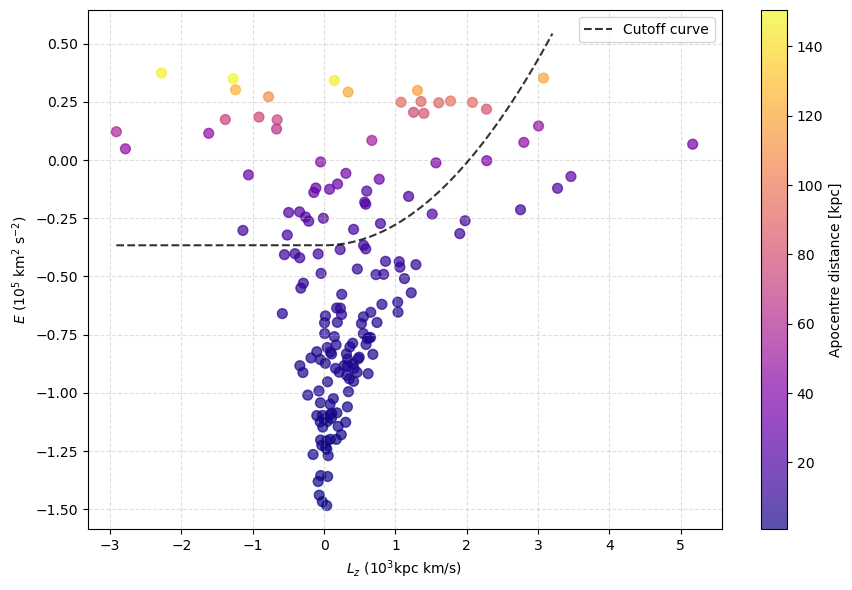

Accretion candidates based on E-Lz criteria:
['Arp2' 'NGC5024' 'Crater' 'IC4499' 'Pal4' 'NGC5694' 'NGC2298' 'NGC4147'
 'Pal14' 'NGC7089' 'NGC5272' 'NGC6934' 'NGC6101' 'NGC5466' 'Pal5' 'Pal15'
 'Pal13' 'NGC5053' 'NGC6715' 'Pal2' 'NGC1261' 'Whiting1' 'NGC5634'
 'NGC7492' 'Terzan7' 'NGC5904' 'IC1257' 'NGC2419' 'Pal12' 'NGC7006'
 'NGC6584' 'NGC3201' 'Rup106' 'NGC6229' 'Pyxis' 'NGC1904' 'NGC1851'
 'Terzan8' 'NGC6981' 'E1' 'NGC6864' 'Eridanus' 'AM4' 'FSR1758' 'Laevens3']
Number of accretion candidates: 45
Total accretion candidates: 46
Found in Harris catalogue: 46
Missing from Harris catalogue: 0

Matches:
   ARP2
   NGC5024
   IC4499
   PAL4
   NGC5694
   NGC2298
   NGC4147
   PAL14
   NGC7089
   NGC5272
   NGC6934
   NGC6101
   NGC5466
   PAL5
   PAL15
   PAL13
   NGC5053
   NGC6715
   PAL2
   NGC1261
   WHITING1
   NGC5634
   NGC7492
   TERZAN7
   IC1257
   NGC2419
   NGC7006
   NGC6584
   NGC3201
   NGC6229
   PYXIS
   NGC1904
   NGC1851
   TERZAN8
   NGC6981
   AM1
   NGC6864
   ERIDAN

In [6]:
# Interesting side job - I'll verify the accretion candidates further by looking at their apocentric distances. 
# I think this unifies the bridge between the dynamical and spatial methods and helps confirm that our sorting is actually working. 
# Same process as before with the galpy inbuilt globular cluster data, but this time also calculating apocentre distances. 
orbits_galpy = Orbit.from_name('MW Globular Clusters')
Lz = []
E = []
apo = []
names = []
for orb in orbits_galpy:
    names.append(orb.name)
    Lz.append(orb.Lz(pot=MWPotential2014))
    E.append(orb.E(pot=MWPotential2014))
    apo.append(orb.rap(pot=MWPotential2014, analytic=True))

Lz = np.array(Lz, dtype=float)
E = np.array(E, dtype=float)
apo = np.array(apo, dtype=float)
names = np.array(names)


# Soft cutoff, softer criteria and narrow down later
L0 = 500
E_cutoff = np.percentile(E, 65)
alpha = alpha = 0.03 * (np.max(E) - E_cutoff) 

def E_boundary(lz):
    return np.where(lz < 0, E_cutoff, E_cutoff + alpha * (lz/L0)**2) # if Lz < 0, straight line, if Lz > 0, parabola

#similar plotting as before, except colour mapping by apocentre distance
mask_accreted = E > E_boundary(Lz)
print(sum(E > E_boundary(Lz)))
fig, ax = plt.subplots(figsize=(9,6))
sc = ax.scatter(Lz/1e3,   E/1e5, c = apo, cmap = 'plasma', s=50, alpha=0.7)
lz_grid = np.linspace(Lz.min(), 3200, 400)
ax.plot(lz_grid/1e3, E_boundary(lz_grid)/1e5,c = 'black', ls = '--',alpha = 0.8, label = 'Cutoff curve')
cbar = plt.colorbar(sc, ax=ax)
cbar.set_label('Apocentre distance [kpc]')
ax.set_xlabel(r'$L_z$ ($10^3$kpc km/s)')
ax.set_ylabel(r'$E$ ($10^5$ km$^2$ s$^{-2}$)')
ax.grid(True, ls='--', alpha=0.4)
ax.legend()
plt.tight_layout()
plt.show()

# Print the names of the accretion candidate clusters
print("Accretion candidates based on E-Lz criteria:")
accretion_candidates1 = np.array(names[mask_accreted])
print(accretion_candidates1)
print(f"Number of accretion candidates: {len(accretion_candidates1)}")

# Below is sime slightly older code to cross match between galpy's list and the harris catalogue.
# Keeping it here for the sake of reference in case I need it later. 
# Normalize Harris catalogue IDs: remove spaces, uppercase
harris_ids_norm = set(data_df['ID'].str.replace(" ", "", regex=False).str.upper())

# Normalize accretion candidate names the same way
candidates_norm = [gc.replace(" ", "").upper() for gc in accretion_candidates]

# Check membership
matches = [gc for gc in candidates_norm if gc in harris_ids_norm]
missing = [gc for gc in candidates_norm if gc not in harris_ids_norm]

# Print results
print(f"Total accretion candidates: {len(accretion_candidates)}")
print(f"Found in Harris catalogue: {len(matches)}")
print(f"Missing from Harris catalogue: {len(missing)}\n")


if matches:
    print("Matches:")
    for m in matches:
        print("  ", m)

if missing:
    print("Missing:")
    for m in missing:
        print("  ", m)


## The spin-up signature (FAILED ATTEMPT)
I will now attempt to unveil the Milky Way's origins by plotting the ages against the metallicities to find the spin-up signature. 
**Metallicities as a chemical timestamp**
In GCs, metallicity acts as a chemical timestamp:

Low [Fe/H] (metal-poor, < –1.5): stars formed very early in the Universe, before many supernovae had enriched the interstellar medium.

Higher [Fe/H] (metal-rich, > –1.0): stars formed later, after multiple generations of stellar evolution had seeded the gas with heavy elements.


**Metallicity and chemical origin**
In-situ clusters (formed inside the Milky Way):

1. Tend to follow the Galaxy’s own chemical enrichment track.

2. Show a “spin-up” transition: at intermediate metallicities ([Fe/H] ≈ –1.3 to –1.0), they begin to rotate coherently with the Galactic disc.

3. Metal-rich clusters ([Fe/H] > –1.0) are strongly associated with the thick and thin disc.


Accreted clusters (brought in by dwarf galaxies):

1. Often have metallicities that don’t fit the Milky Way’s age–metallicity relation.

2. Dwarf galaxies enriched more slowly, so their clusters can be relatively young but still metal-poor.

3. This mismatch is a key signature of external origin.

**The spin up signature**
When plotted against metallicity, in-situ clusters show a transition:

1. Low-metallicity clusters ([Fe/H] < –1.5): random, halo-like kinematics, no net rotation.

2. Intermediate metallicity ([Fe/H] ≈ –1.3 to –1.0): clear increase in  𝑉𝜙— the spin-up signature.

3. Higher metallicity ([Fe/H] > –1.0): strong disc-like rotation, consistent with formation in the Milky Way’s disc.


In [7]:
# Replicating Sarvpreet's code for the cluster list common to both krause and vandenberg, cleaned up for mismatches
harrisP1 = pd.read_csv("data/HarrisPartI.csv")
harrisP3 = pd.read_csv("data/HarrisPartIII.csv")
Krause = pd.read_csv("data/Krause21.csv")
VandenBerg = pd.read_csv("data/vandenBerg_table2.csv")

def norm_ids(series):
    return series.dropna().astype(str).str.replace(r"\s+","",regex=True).str.upper()
kraus_ids=set(norm_ids(Krause["Object"]))
VandenBerg.iloc[:,0] = "NGC" + VandenBerg.iloc[:,0].astype(str)

list_accreted = ['Arp2' ,'NGC5024' ,'Crater' ,'IC4499', 'Pal4' ,'NGC5694' ,'NGC2298', 'NGC4147',
 'Pal14' ,'NGC7089' ,'NGC5272', 'NGC6934', 'NGC6101', 'NGC5466', 'Pal5' ,'Pal15',
 'Pal13' ,'NGC5053', 'NGC6715', 'Pal2', 'NGC1261', 'Whiting1' ,'NGC5634',
 'NGC7492', 'Terzan7', 'NGC5904' ,'IC1257', 'NGC2419' ,'NGC7006' ,'NGC6584',
 'NGC3201' ,'NGC6229' ,'Pyxis', 'NGC1904', 'NGC1851', 'NGCTer8', 'NGC6981' ,'E1',
 'NGC6864', 'Eridanus' ,'AM4', 'FSR1758']
set_accreted = set(list_accreted)
Krause_filtered = Krause[Krause["Object"].isin(set_accreted)]
VandenBerg_filtered = VandenBerg[VandenBerg["#NGC"].isin(set_accreted)]
VandenBerg_filtered= VandenBerg_filtered.rename(columns={"#NGC":"ID"})
union_GCs= pd.concat([Krause_filtered, VandenBerg_filtered], ignore_index=True)
Accreted = pd.merge(Krause_filtered, VandenBerg_filtered, left_on="Object", right_on="ID", how="outer",  suffixes=("_K", "_V"))
Union = pd.merge(Krause, VandenBerg, left_on="Object", right_on="#NGC", how="outer",  suffixes=("_K", "_V"))

Accreted["Age"] = Accreted["Age_V"].combine_first(Accreted["Age_K"])
Accreted["FeH"] = Accreted["FeH_V"].combine_first(Accreted["FeH_K"])
Accreted["ID"] = Accreted["Object"].combine_first(Accreted["ID"])
Accreted["ID"] = Accreted["ID"].combine_first(Accreted["Object"])
Union["Age"] = Union["Age_V"].combine_first(Union["Age_K"])
Union["FeH"] = Union["FeH_V"].combine_first(Union["FeH_K"])
Union["ID"] = Union["Object"].combine_first(Union["#NGC"])
Union["ID"] = Union["#NGC"].combine_first(Union["Object"])

Accreted = Accreted.drop(columns=["Age_K", "Age_V", "FeH_K", "FeH_V","Object","AltName","Object","Name"])
Union = Union.drop(columns=["Age_K", "Age_V", "FeH_K", "FeH_V","AltName","Object","#NGC","Name"])

InSitu = Union[~Union["ID"].isin(Accreted["ID"])].copy()
InSitu.reset_index(drop=True, inplace=True)


In [8]:
#Get galpy orbits and compute v_phi instead of Lz. I had previously tried this and it also didn't work. 
orbits = Orbit.from_name('MW Globular Clusters')
galpy_names = [str(o.name) for o in orbits]
galpy_vphi = [o.vphi(pot=MWPotential2014) for o in orbits] 

#Normalise galpy names: uppercase and remove spaces
galpy_norm = [n.upper().replace(' ', '') for n in galpy_names]

# Build mapping and map into merged (in-place)

galpy_map = dict(zip(galpy_norm, galpy_vphi))    # Now mapping to vphi instead of Lz
merged['vphi'] = merged['ID'].map(galpy_map) 

# 4) quick report
n_matched = merged['vphi'].notna().sum()
print(f"Assigned vphi to {n_matched} / {len(merged)} rows in merged.")

# list IDs that didn't get a vphi
if n_matched < len(merged):
    print("Missing vphi for IDs:", merged.loc[merged['vphi'].isna(), 'ID'].tolist())
print(merged.keys())

acc = Accreted.copy()
acc['ID'] = (acc['ID'].astype(str)
                       .str.strip()
                       .str.upper()
                       .str.replace(r'\s+','', regex=True))


acc['ID'] = acc['ID'].replace({
    'Ruprecht106': 'RUP106',
    'Terzan7': 'TERZAN7',
    'NGCTer8': 'TERZAN8',
    'NGCPal12': 'PAL12',
})

acc_set = set(acc['ID'])
merged['Accreted'] = merged['ID'].astype(str).str.strip().str.upper().str.replace(r'\s+','', regex=True).isin(acc_set)

plot_df = merged.dropna(subset=['vphi', 'FeH']).copy()  

print(f"Total merged rows: {len(merged)}")
print(f"Rows with vphi & FeH available: {len(plot_df)}")
print(f"Accreted clusters in plotted sample: {plot_df['Accreted'].sum()}")

fig, ax = plt.subplots(figsize=(8,6))

for acc_status, group in plot_df.groupby('Accreted'):
    label = 'Accreted' if acc_status else 'Not accreted'
    ax.scatter( group['FeH'],group['vphi'], label=label, alpha=0.85)

ax.set_ylabel('v_phi (km/s)')
ax.set_xlabel('[Fe/H]')
ax.set_ylim(-200,200)
ax.set_title('[Fe/H] vs v_phi — coloured by accreted membership')
ax.grid(True, linestyle=':', linewidth=0.5)
ax.legend()
plt.show()

NameError: name 'merged' is not defined